In [1]:
import warnings
warnings.simplefilter(action='ignore')
import numpy as np
import pandas as pd
from copy import deepcopy
from sklearn.preprocessing import LabelEncoder

from melusine import load_email_data

# Text input 
df_emails_preprocessed = load_email_data(type="full")
df_emails_preprocessed['clean_text'] = df_emails_preprocessed['clean_header'] + " " + df_emails_preprocessed['clean_body']

In [2]:
# Requirement : have a pretrained Embedding
from melusine.nlp_tools.embedding import Embedding
pretrained_embedding = Embedding(tokens_column="tokens", workers=1, min_count=5)
pretrained_embedding.train(df_emails_preprocessed)

In [3]:
# Metadata input
df_meta = pd.read_csv('/home/jupyter/melusine/melusine/data/metadata.csv', encoding='utf-8', sep=',')

# Dataset
X = pd.concat([df_emails_preprocessed['clean_text'],df_meta],axis=1)
y = df_emails_preprocessed['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [4]:
import ast
import pandas as pd
import numpy as np
df_emails_preprocessed = pd.read_pickle('/home/jupyter/melusine/melusine/data/emails_preprocessed.pkl')

df_emails_preprocessed['clean_header'] = df_emails_preprocessed['clean_header'].astype(str)
df_emails_preprocessed['clean_body'] = df_emails_preprocessed['clean_body'].astype(str)
df_emails_preprocessed['attachment'] = df_emails_preprocessed['attachment'].apply(ast.literal_eval)
df_emails_preprocessed['clean_text'] = df_emails_preprocessed['clean_header'] + " " + df_emails_preprocessed['clean_body']

In [5]:
X = pd.concat([df_emails_preprocessed['clean_text'],df_meta],axis=1)

In [6]:
from sklearn.preprocessing import LabelEncoder
y = df_emails_preprocessed['label']
le = LabelEncoder()
y = le.fit_transform(y)

In [7]:
from melusine.models.train import NeuralModel

In [8]:
len(np.unique(y))

11

# Deterministic model

#### The deterministic model is able to give us **point estimation**. 

In [9]:
from melusine.models.neural_architectures import cnn_model
deterministic_nn_model = NeuralModel(architecture_function=cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [10]:
deterministic_nn_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_deterministic = deterministic_nn_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 1s 38ms/step - loss: 2.3927 - accuracy: 0.0750
Epoch 2/40
2/2 [==============================] - 0s 36ms/step - loss: 2.3019 - accuracy: 0.2500
Epoch 3/40
2/2 [==============================] - 0s 36ms/step - loss: 2.2006 - accuracy: 0.2750
Epoch 4/40
2/2 [==============================] - 0s 34ms/step - loss: 2.0889 - accuracy: 0.3250
Epoch 5/40
2/2 [==============================] - 0s 37ms/step - loss: 2.1336 - accuracy: 0.3000
Epoch 6/40
2/2 [==============================] - 0s 41ms/step - loss: 1.9852 - accuracy: 0.2500
Epoch 7/40
2/2 [==============================] - 0s 44ms/step - loss: 1.8534 - accuracy: 0.3250
Epoch 8/40
2/2 [==============================] - 0s 40ms/step - loss: 1.9144 - accuracy: 0.2500
Epoch 9/40
2/2 [==============================] - 0s 38ms/step - loss: 1.8015 - accuracy: 0.4750
Epoch 10/40
2/2 [==============================] - 0s 37ms/step - loss: 1.7616 - accuracy: 0.3000
Epoch 11/40
2/2 [============

In [11]:
deterministic_nn_model.predict_proba(X)[:2]

2/2 [==============================] - 0s 9ms/step


array([[0.00536734, 0.00755896, 0.10579307, 0.68630296, 0.14638655,
        0.00924158, 0.00776025, 0.00112215, 0.00459163, 0.00146511,
        0.02441036],
       [0.01623694, 0.00251714, 0.0092525 , 0.01100623, 0.01123379,
        0.00283276, 0.00965934, 0.00188893, 0.02051709, 0.00164669,
        0.91320866]], dtype=float32)

In [12]:
deterministic_nn_model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 100, 300)     5700        ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 100, 200)     120200      ['embedding[0][0]']              
                                                                                                  
 spatial_dropout1d (SpatialDrop  (None, 100, 200)    0           ['conv1d[0][0]']                 
 out1D)                                                                                       

#### We can propose a way to have **uncertainty estimation**

# The probabilitic model 
The probabilitic gives us not longer point estimation but distribution on predictions. It allows us to give prediction intervals.

In [13]:
from melusine.models.probabilistic_neural_architectures import probabilistic_cnn_model
probabilistic_model = NeuralModel(architecture_function=probabilistic_cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [14]:
probabilistic_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_probabilistic = probabilistic_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 2s 35ms/step - loss: 2.3925 - accuracy: 0.1750
Epoch 2/40
2/2 [==============================] - 0s 37ms/step - loss: 2.2533 - accuracy: 0.2750
Epoch 3/40
2/2 [==============================] - 0s 34ms/step - loss: 2.1661 - accuracy: 0.3250
Epoch 4/40
2/2 [==============================] - 0s 34ms/step - loss: 2.0746 - accuracy: 0.3500
Epoch 5/40
2/2 [==============================] - 0s 34ms/step - loss: 1.9506 - accuracy: 0.3500
Epoch 6/40
2/2 [==============================] - 0s 31ms/step - loss: 1.8673 - accuracy: 0.4000
Epoch 7/40
2/2 [==============================] - 0s 32ms/step - loss: 1.9767 - accuracy: 0.4000
Epoch 8/40
2/2 [==============================] - 0s 31ms/step - loss: 1.8035 - accuracy: 0.4250
Epoch 9/40
2/2 [==============================] - 0s 32ms/step - loss: 1.7111 - accuracy: 0.5000
Epoch 10/40
2/2 [==============================] - 0s 33ms/step - loss: 1.6401 - accuracy: 0.4750
Epoch 11/40
2/2 [============

### The estimation of the probability is now the mean of the distribution of the prediction

The output of the model is not a **vector** but a **distribution** we can :
- sample
- compute mean
- compute std

In [15]:
X_input = probabilistic_model.prepare_email_to_predict(X)
output = probabilistic_model.model(X_input)
print(type(output)) # this is not a numeric output ! the output is a distribution

<class 'tensorflow_probability.python.util.deferred_tensor.OneHotCategorical'>


#### We can have a **point estimation** using the **mode** or the **mean**

In [16]:
output.mean().numpy().round(1)[:2]

array([[0. , 0. , 0. , 0.4, 0.1, 0.1, 0.1, 0. , 0. , 0. , 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]],
      dtype=float32)

In [17]:
output.mode()[:2]

<tf.Tensor: shape=(2, 11), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)>

#### We can have the **standard deviation** of the distributions

In [18]:
output.stddev().numpy().round(1)[:2]

array([[0.2, 0.1, 0.2, 0.5, 0.3, 0.3, 0.2, 0.1, 0.1, 0.2, 0.4],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1]],
      dtype=float32)

#### We can even **sample** the distributions
**this sampling will have different results at each execution !**

In [19]:
sampling_of_predictions = output.sample()[:10]
sampled_labels = np.argmax(sampling_of_predictions, axis=1)
le.inverse_transform(sampled_labels)

array(['compte', 'vehicule', 'autres', 'vehicule', 'adhesion',
       'modification', 'resiliation', 'vehicule', 'habitation',
       'vehicule'], dtype=object)

#### The mode can be used for `predict`

In [20]:
prediction = probabilistic_model.predict(X)[:2]
le.inverse_transform(prediction)

array(['compte', 'vehicule'], dtype=object)

#### The mean is used for `predict_proba`

In [21]:
probabilistic_model.predict_proba(X).round(1)[:2]

array([[0. , 0. , 0. , 0.4, 0.1, 0.1, 0.1, 0. , 0. , 0. , 0.2],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]],
      dtype=float32)

#### And prediction intervals are made by combining **mean** and **std** (gaussian hypothesis)
We could also imagine to sample multiple times the distribution and use the samples to estimate uncertainty.

In [22]:
score, inf, sup = probabilistic_model.predict_proba(X, prediction_interval=0.95)

In [23]:
inf.round(1)[-2:] # lower_boundary

array([[0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.9]],
      dtype=float32)

In [24]:
sup.round(1)[-2:] # upper_boundary

array([[0.3, 0.3, 0.4, 1. , 0.7, 0.7, 0.4, 0.3, 0.3, 0.5, 1. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ]],
      dtype=float32)

In [25]:
import matplotlib.pyplot as plt
ntargets = 11


def analyse_and_plot_model_predictions(data, true_labels, nn_model, text_num, pi=0.95):
    """
    Make plots of the probabilities that the model estimates for a given text
    """
    true_label = true_labels[text_num]
    true_label_decoded = le.inverse_transform([true_label])[0]
    print('True label: \033[1m \033[92m {} \033[0m'.format(str(true_label_decoded)))
    print('Clean text: ', data.loc[text_num, "clean_text"])
    model_prediction, pct_low, pct_up = nn_model.predict_proba(data.loc[text_num:text_num], prediction_interval=pi)
    model_prediction, pct_low, pct_up = model_prediction[0], pct_low[0], pct_up[0]
    x_pos = np.arange(ntargets)
    bar = plt.bar(x_pos, pct_up, color='red')
    all_categories_decoded = le.inverse_transform(np.arange(ntargets))
    plt.xticks(x_pos, all_categories_decoded, color='black', rotation=45, fontweight='bold', fontsize='10', horizontalalignment='right')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    ticks = ax.get_xticks()
    for label, tick in zip(labels, ticks):
        if tick == true_label:
            label.set_color('green')
    bar[true_label].set_color('green')
    plt.bar(np.arange(ntargets), pct_low, color='white', linewidth=1, edgecolor='white')
    ax.plot(np.arange(ntargets), model_prediction, "ob")
    plt.ylim([0, 1])
    plt.ylabel('Probability')
    plt.title('Model estimated probabilities') 
    plt.show()

True label:   vehicule 
Clean text:  immatriculation voiture je vous informe que la nouvelle immatriculation est enfin faite. je vous prie de trouver donc la carte grise ainsi que la nouvelle immatriculation. je vous demanderai de faire les changements necessaires concernant lassurance.


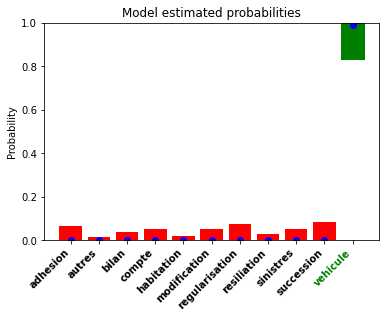

In [26]:
i = 1
analyse_and_plot_model_predictions(X, y, probabilistic_model, text_num=i, pi=0.95)

So instead of just having a point estimation score of being a `vehicle` verbatim (score=0.99) we can have uncertainty estimation around a point estimation (the score of being `vehicle` verbatim is in the interval [0.8 ; 1] with a 95% prediction interval).

### Disclaimer
The dataset of this melusine tutorial is so small (40 emails) the model is always drawing large intervals. On the previous example the prediction interval may be [0;1] (thank you captain obvious). We would rather consider small (more informative) intervals.


But if we apply this method on a large public datasets (like the movies dataset : 100 000 movies plots) we can see predictions with less uncertainty as on the following image. With disjointed intervals.

<img src="images/uncertainty-on-movies-dataset.png" width=400 height=400 />

To let us see small interval (as a sanity check) we also can choose a very small prediction interval (0.2 instead of 0.95, but obviously 0.2 is not a serious value for prediction intervals) as on the following.

True label:   vehicule 
Clean text:  assurance vehicules je me permets de venir vers vous car depuis le debut de lannee, nous avons des difficultes pour assurer nos vehicules. ces derniers jours, vous nous avez fait parvenir le detail des denominations et des niveau dassurance de chaque vehicule. merci deffectuer ces changements dans lattente de votre retour


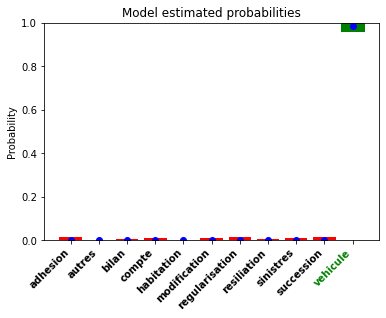

In [27]:
i = 7
analyse_and_plot_model_predictions(X, y, probabilistic_model, text_num=i, pi=0.2) # warn : this prediction interval is too small !!!

# To go further : variational neural networks
We can try a variational neural networks : [`Flipout`](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/conv_variational)

In [28]:
from melusine.models.probabilistic_neural_architectures import flipout_cnn_model
flipout_nn_model = NeuralModel(architecture_function=flipout_cnn_model,
                       pretrained_embedding=pretrained_embedding,
                       text_input_column="clean_text",
                       batch_size=20,
                       meta_input_list=['extension','attachment_type', 'dayofweek', 'hour', 'min'],
                       n_epochs=40)

In [29]:
flipout_nn_model.fit(X,y,tensorboard_log_dir="tutorial/data")
accuracy_flipout= flipout_nn_model.score(X, y)

Epoch 1/40
2/2 [==============================] - 2s 24ms/step - loss: 18790.9727 - accuracy: 0.0250
Epoch 2/40
2/2 [==============================] - 0s 25ms/step - loss: 18775.3633 - accuracy: 0.0250
Epoch 3/40
2/2 [==============================] - 0s 23ms/step - loss: 18759.7852 - accuracy: 0.0250
Epoch 4/40
2/2 [==============================] - 0s 25ms/step - loss: 18744.2402 - accuracy: 0.0250
Epoch 5/40
2/2 [==============================] - 0s 24ms/step - loss: 18728.7266 - accuracy: 0.0250
Epoch 6/40
2/2 [==============================] - 0s 26ms/step - loss: 18713.2422 - accuracy: 0.0250
Epoch 7/40
2/2 [==============================] - 0s 26ms/step - loss: 18697.7910 - accuracy: 0.0000e+00
Epoch 8/40
2/2 [==============================] - 0s 25ms/step - loss: 18682.3691 - accuracy: 0.0250
Epoch 9/40
2/2 [==============================] - 0s 26ms/step - loss: 18666.9824 - accuracy: 0.0250
Epoch 10/40
2/2 [==============================] - 0s 24ms/step - loss: 18651.6211 - ac

In [30]:
flipout_nn_model.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 100, 300)     6900        ['input_5[0][0]']                
                                                                                                  
 conv1d_flipout (Conv1DFlipout)  (None, 100, 128)    230528      ['embedding_2[0][0]']            
                                                                                                  
 input_6 (InputLayer)           [(None, 66)]         0           []                               
                                                                                            

### Another disclaimer
The tutorial dataset is too small (40 emails) for the flipout model.

This kind of model needs a lot of data and is difficult to configure.

True label:   vehicule 
Clean text:  immatriculation voiture je vous informe que la nouvelle immatriculation est enfin faite. je vous prie de trouver donc la carte grise ainsi que la nouvelle immatriculation. je vous demanderai de faire les changements necessaires concernant lassurance.


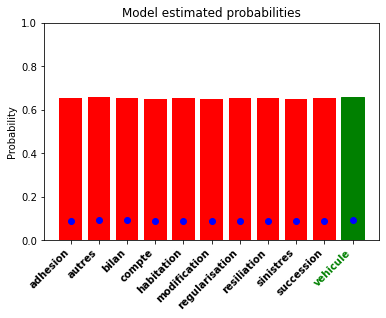

In [31]:
i = 1
analyse_and_plot_model_predictions(X, y, flipout_nn_model, i)

### Quick summary
We show 2 probabilistic models :
- **basic probabilistic** model with just a [OneHotCategorical](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/OneHotCategorical) as last (prediction) layer

- **flipout** model with [Convolution1DFlipout](https://www.tensorflow.org/probability/api_docs/python/tfp/layers/Convolution1DFlipout) layers

We made simulations on a larger dataset (the movies plots dataset) to see if the probabilistic models had a good enough performance.

The basic probabilistic model is an effective lowcost solution to have uncertainty estimation of the prediction without any performance loss.

On our case, we did not manage to design a variational (flipout) neural architecture to get this level of performance.

## Practical - *What is it for ?*

If you are using Melusine in an automated task, you may need to estimate the **uncertainty** of your decisions. Especially if an error can have consequences for your end-users.

Maybe have you planned to use a *threshold on the point estimation* to automate your decision :


````python
    if score>0.7:
        we automate the decision
    else:
        the decision will be validated manually
````



**This is a good start. But is it enough ?**

Indeed imagine your *point estimation* tells you this email has a `score=0.75 of beeing an adhesion email` but what is the **uncertainty around this point estimation** ? Maybe the uncertainty around this point estimation is so large that your estimation is in fact in the interval `[0.55;0.95]`, in this case are sure you can automate this decision ? 

Instead of using threshold on a **point estimation**, you could rely on a threshold on the **lower bound of the prediction interval** and better managing your **risk of error**. So you will automise the email your model categorize with a high **point estimation** AND a **low uncertainty**.

In [32]:
email_to_predict = X.loc[1:1]
deterministic_nn_model.predict_proba(email_to_predict).round(2)

1/1 [==============================] - 0s 25ms/step


array([[0.02, 0.  , 0.01, 0.01, 0.01, 0.  , 0.01, 0.  , 0.02, 0.  , 0.91]],
      dtype=float32)

The **point estimation** of the deterministic model is around `0.9` for beeing a `vehicle email`

In [33]:
point_estimation, lower_bound, upper_bound = probabilistic_model.predict_proba(email_to_predict, prediction_interval=0.95)

In [34]:
point_estimation.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.99]],
      dtype=float32)

The probabilistic model also gives a **point estimation** near 0.9.

In [35]:
lower_bound.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.83]],
      dtype=float32)

But it also gives us a **lower bound** ! (and also **upper bound** but in this particular case we don't use it)

The point estimation is very high (more then 0.9) but we can build our decision on the lower bound **0.8** and decide it is **high enough to automate the decision**. 

### Let's make another prediction with high uncertainty

In [36]:
email_to_predict = X.loc[2:2]
deterministic_nn_model.predict_proba(email_to_predict).round(2)

1/1 [==============================] - 0s 21ms/step


array([[0.  , 0.01, 0.16, 0.78, 0.04, 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

The **point estimation** of the deterministic model is around `0.8` for beeing a `compte email` so the first decision may be to automate the decision. But what about the uncertainty ?

In [37]:
point_estimation, lower_bound, upper_bound = probabilistic_model.predict_proba(email_to_predict, prediction_interval=0.95)

In [38]:
point_estimation.round(2)

array([[0.02, 0.01, 0.04, 0.74, 0.01, 0.03, 0.02, 0.01, 0.01, 0.01, 0.11]],
      dtype=float32)

In [39]:
lower_bound.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

The uncertainty is so high around those predictions (lower bound around 0) we could conclude not to automated this decision.